In [0]:
import pandas as pd
import json
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [0]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns=['table_id','school_dist'])
price = call_df('crawling_db.price_table').drop(columns='price_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')

In [0]:
df = (price.merge(apartment, how='left', on='apartment_id').
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left', on='apartment_id'))

In [0]:
import re
df['area'] = df['area'].apply(lambda x: int(re.split('\D',x)[0]))

In [0]:
df = df.drop(['school_addr_district','period','amount_original'],axis=1)
df['school_students'] = pd.to_numeric(df['school_students'])

In [0]:
df.columns

Index(['apartment_id', 'area', 'year', 'month', 'amount', 'district_id',
       'apartment_addr_town', 'apartment_builder', 'apartment_build_year',
       'apartment_build_month', 'apartment_floor_min', 'apartment_floor_max',
       'apartment_parking', 'apartment_name', 'district_name', 'school_name',
       'school_addr_town', 'school_students', 'st_name', 'st_dist',
       'st_volume'],
      dtype='object')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457904 entries, 0 to 457903
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   apartment_id           457904 non-null  int64  
 1   area                   457904 non-null  int64  
 2   year                   457904 non-null  int64  
 3   month                  457904 non-null  int64  
 4   amount                 457904 non-null  int64  
 5   district_id            457904 non-null  int64  
 6   apartment_addr_town    457904 non-null  object 
 7   apartment_builder      457904 non-null  object 
 8   apartment_build_year   457904 non-null  int64  
 9   apartment_build_month  457904 non-null  int64  
 10  apartment_floor_min    457904 non-null  object 
 11  apartment_floor_max    457904 non-null  object 
 12  apartment_parking      457904 non-null  float64
 13  apartment_name         457904 non-null  object 
 14  district_name          457904 non-nu

# 연도별 거래액



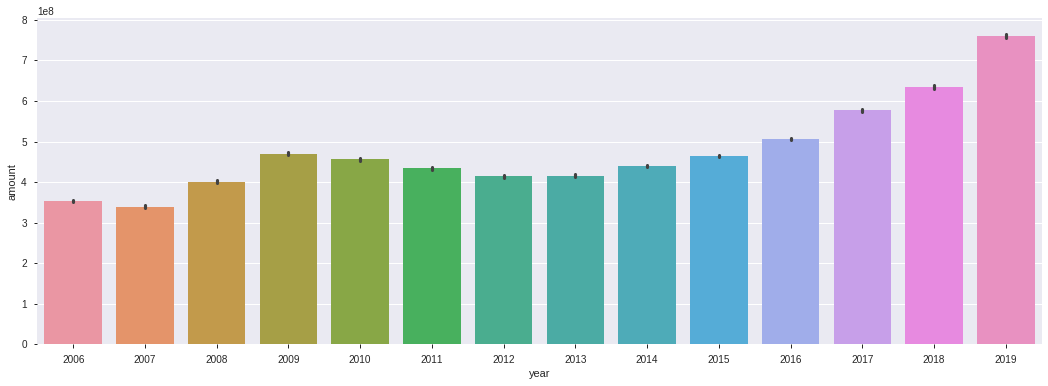

In [0]:
#2020년도의 경우 5월달까지의 거래액만 존재해서 제외
a = df[df['year']<2020]
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 

sns.barplot(data=a,x="year",y="amount",ax=ax1)

- 2009년도부터 2013년까지의 실거래가가 감소하나, 2013년도부터 실거래가 증가

# 자치구별 거래액

- 실거래가를 자치구별로 나타내고, 이상치를 제거했다

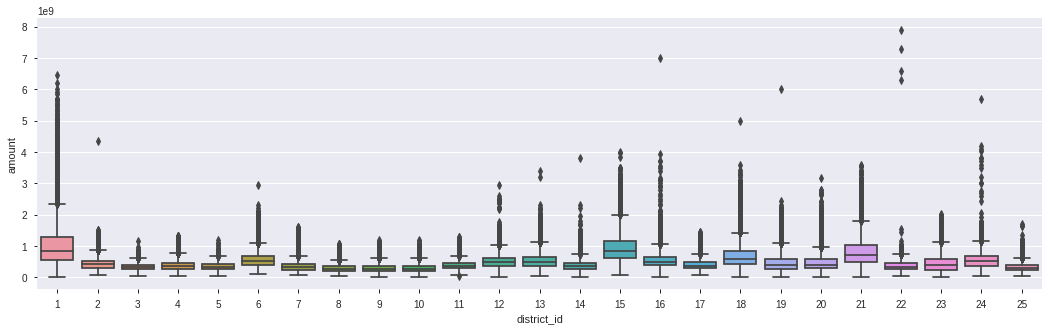

In [0]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

- 이상치는 동일 면적의 해당 아파트 거래가 한번인 경우 제거하지 않았다
- 해당 아파트에 대한 거래 정보가 없어지기 때문

In [0]:
#이상치 제거
df.drop(df[df['district_id']==2].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==6].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==12].sort_values(by='amount',ascending=False).head(5).index,inplace=True)
#df.drop(df[df['district_id']==13].sort_values(by='amount',ascending=False).head(2).index,inplace=True) 거래가 총 2번 이루어져서 제거 안함
df.drop(df[df['district_id']==14].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==16].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==18].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==19].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==22].sort_values(by='amount',ascending=False).head(3).index,inplace=True)#신호아파트 면적97인 아파트의 경우 한번 거래가 이루어져 제거 안함
df.drop(df[df['district_id']==24].sort_values(by='amount',ascending=False).head(1).index,inplace=True)

In [0]:
# df[df['district_id']==22].sort_values(by='amount',ascending=False).head(4)[['apartment_name','area','amount']]

In [0]:
# df[(df['apartment_name']=='신호')&(df['area']==132)]

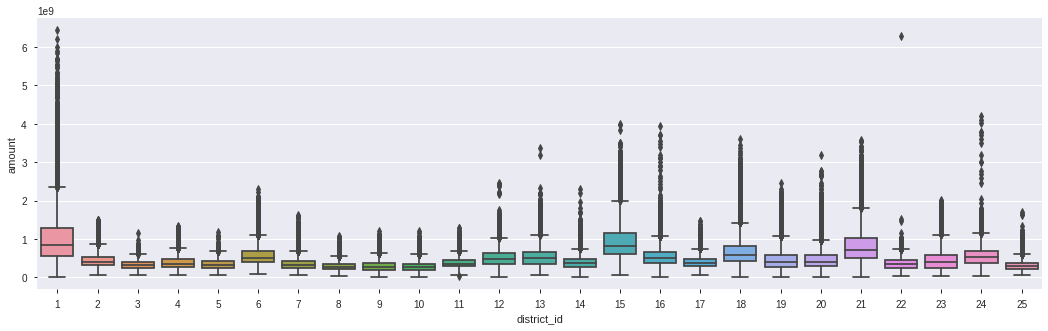

In [0]:
#이상치를 제거한 boxplot
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

- 이상치를 제거한 이후의 자치구별 실거래가 boxplot

# 학교정보

In [0]:
df['school_name'].nunique()

538

- 538개의 학교가 있으며, 초등학교만 존재

In [0]:
#학생 수에 결측값이 생겨서 0으로 우선 바꿔준다
df2 = df.dropna()
#학교별 학생수와 거래가의 평균을 구함
df2 = df2.groupby('school_name').mean()[['school_students','amount']].dropna()
df2 = pd.merge(df2,df[['district_name','school_name']],how='left',on='school_name').drop_duplicates()
df2.reset_index(inplace=True)
df2.head()
df2[df2['school_students']>2000] #학생수가 2000명 넘는 학교

,index,school_name,school_students,amount,district_name
103,85817,서울대도초등학교,2157.0,1.449975e+09,강남구


- 학생수가 2000명 넘는 학교는 한군데, 서울대도초등학교 >> 제외하고 분석

In [0]:
#대도초등학교 제외하고 분포 살펴보기
df2 = df2[df2['school_students']<2000]

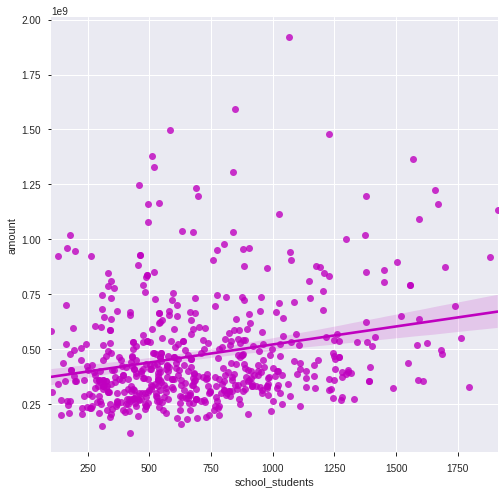

In [0]:
figure,ax1 = plt.subplots()
figure.set_size_inches(8,8) 

sns.regplot(x="school_students",y="amount",data=df2,color="m",ax=ax1)

- 학생수와 amount는 양의 상관관계를 갖는다 > 학생수를 구간별로 나눠서 살펴보자

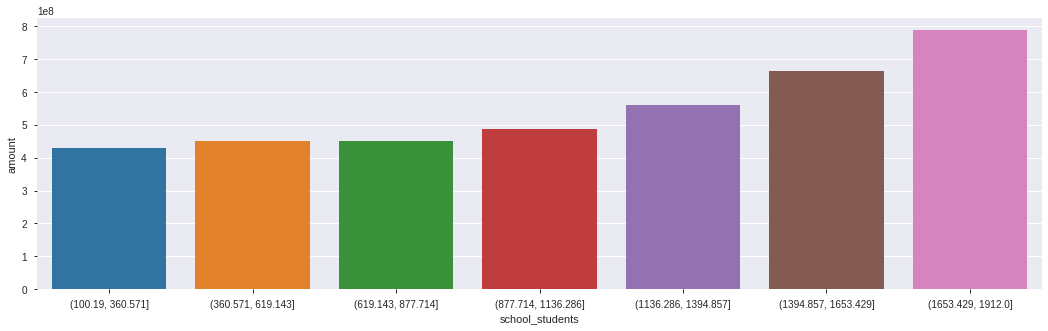

In [0]:
factor = pd.cut(df2.school_students,7)
a = df2.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()


figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="school_students",y="amount",ax=ax1)

- 학생 수가 877명 이하인 경우에는 학생수에 따른 amount의 값이 비슷하다
- 학생 수가 877명 이상인 경우 학생수가 많은 학교가 주변에 있을 경우 거래액이 높아짐

- 이번에는 자치구 세대수와 학교 학생수의 비율에 따른 거래액의 변화를 살펴보자

In [0]:
df2.head()

,index,school_name,school_students,amount,district_name
0,0,서울가곡초등학교,879.0,4.794164e+08,강서구
1,562,서울가동초등학교,947.0,6.759128e+08,송파구
2,1769,서울가락초등학교,812.0,7.367314e+08,송파구
3,1984,서울가산초등학교,333.0,3.073168e+08,구로구
4,2233,서울가산초등학교,333.0,3.073168e+08,금천구


In [0]:
population = pd.read_excel("population.xlsx")
population.drop(['※ 매년 말일자 통계 현황','Unnamed: 4'],axis=1,inplace=True)
population.drop([0,1,2],inplace=True)
population.rename(columns={'Unnamed: 1':'district_name','Unnamed: 2':'총인구수','Unnamed: 3':'세대수'},inplace=True)

In [0]:
population['district_name'] = population.district_name.str.split(' ').str[1]
population['세대수'] = population.세대수.str.replace(',', '').astype('int64')

In [0]:
population.head()

,district_name,총인구수,세대수
3,종로구,"151,290",73947
4,중구,"126,171",62739
5,용산구,"228,670",110126
6,성동구,"300,889",135838
7,광진구,"351,350",164428


In [0]:
df1 = pd.merge(df2,population,how='left',on='district_name')
df1['ratio'] = 0.0
for ind in df1.index:
  a = float(df1['세대수'][ind])
  b = float(df1['school_students'][ind])
  df1['ratio'][ind] = b/a
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,school_name,school_students,amount,district_name,총인구수,세대수,ratio
0,0,서울가곡초등학교,879.0,4.794164e+08,강서구,"591,796",262708,0.003346
1,562,서울가동초등학교,947.0,6.759128e+08,송파구,"675,961",278711,0.003398
2,1769,서울가락초등학교,812.0,7.367314e+08,송파구,"675,961",278711,0.002913
3,1984,서울가산초등학교,333.0,3.073168e+08,구로구,"406,664",176568,0.001886
4,2233,서울가산초등학교,333.0,3.073168e+08,금천구,"232,810",110622,0.003010


- ratio는 각 자치구별 세대수와 학교 학생 수의 비율을 나타낸 것

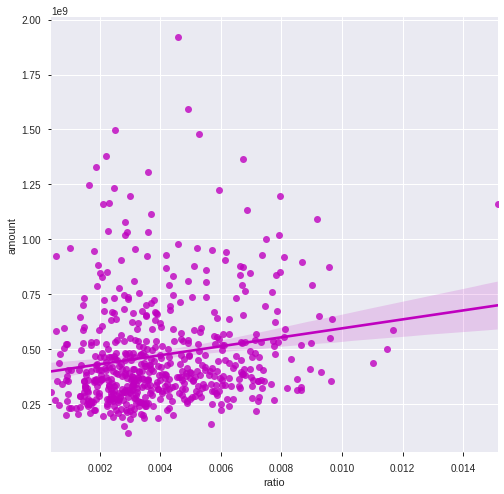

In [0]:
figure,ax1 = plt.subplots()
figure.set_size_inches(8,8) 

sns.regplot(x="ratio",y="amount",data=df1,color="m",ax=ax1)

- 자치구별 세대수대비 학교 학생수가 많을 수록 아파트의 실거래가가 높아진다

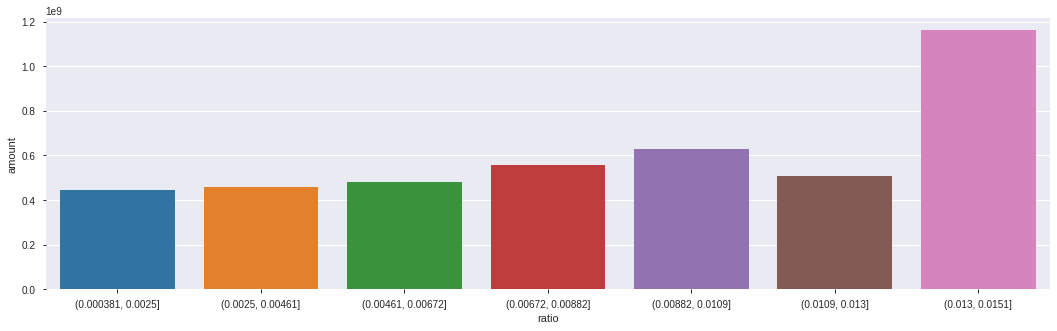

In [0]:
factor = pd.cut(df1.ratio,7)
a = df1.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()


figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="ratio",y="amount",ax=ax1)

- 모든 구간에서 양의 상관관계를 가지지는 않는다 [0.0109,0.013]의 구간에 해당하는 지역이 어디인지 살펴보자

- 서울가재울초등학교, 서울세검정초등학교, 서울청구초등학교 주변 아파트의 경우 자치구 인구대비 학교 학생 수가 많음에도 불구하고 실거래가의 평균이 낮다

In [0]:
df1[(df1['ratio']>0.0109)&(df1['ratio']<=0.013)]

,index,school_name,school_students,amount,district_name,총인구수,세대수,ratio
8,5232,서울가재울초등학교,1547.0,4.372636e+08,서대문구,"309,397",140157,0.011038
272,217491,서울세검정초등학교,864.0,5.874526e+08,종로구,"151,290",73947,0.011684
519,423319,서울청구초등학교,720.0,5.037685e+08,중구,"126,171",62739,0.011476


# 세대당 주차대수

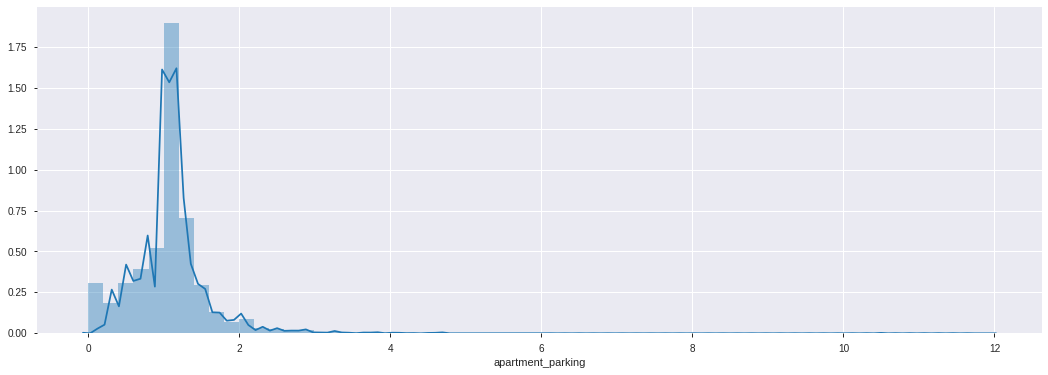

In [0]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 
sns.distplot(df['apartment_parking'],ax=ax1,bins=60)

- 세대당 주차대수는 0~2대 사이에 주로 분포

In [0]:
df[df['apartment_parking']>=5][['apartment_name','apartment_parking']].drop_duplicates() #5대 이상인 아파트는 7개 > 우선 제외하고 분석

,apartment_name,apartment_parking
5636,S-타워,7.36
10782,도곡푸르지오2차,6.07
16008,현대타워,5.03
237652,삼성보라매옴니타워,6.04
243717,마포트라팰리스,11.95
293300,리버마이다스빌,6.50
326957,코업스타클래스,10.52


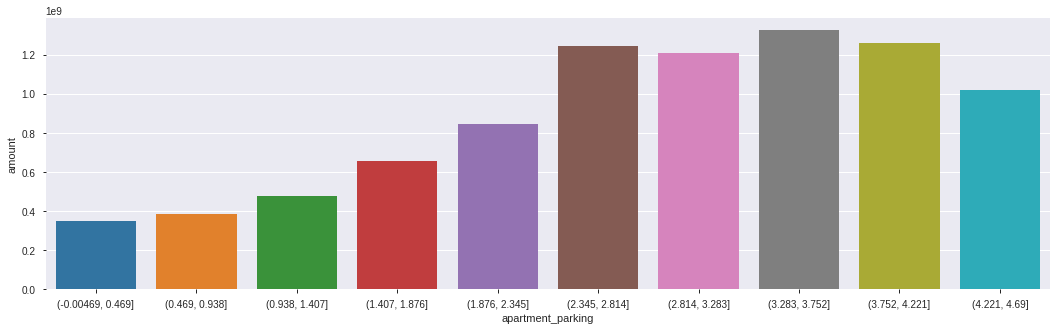

In [0]:
df2 = df[df['apartment_parking']<=5]
factor = pd.cut(df2.apartment_parking,10)
a = df2.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="apartment_parking",y="amount",ax=ax1)

- 세대당 주차대수가 2.8대 이하인 경우 양의 상관관계를 가지나, 그 이후는 들쑥날쑥
- 4.2대가 넘는 구간에서 amount가 크게 감소

# 준공연도

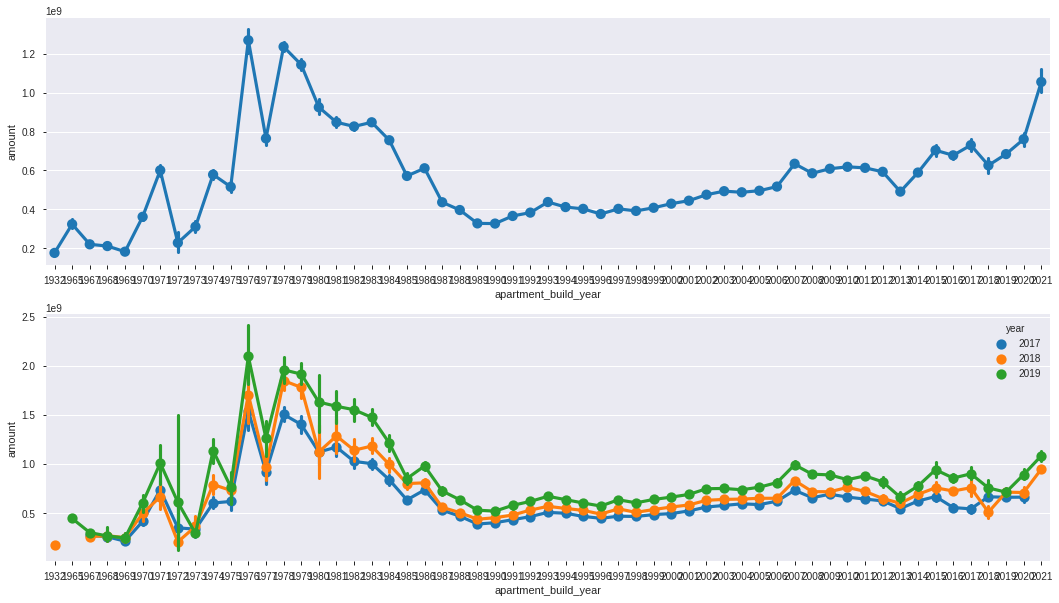

In [0]:
figure,(ax1,ax2) = plt.subplots(nrows=2)
figure.set_size_inches(18,10) 

sns.pointplot(data=df,x="apartment_build_year",y="amount",ax=ax1)
df1 = df[(df['year']==2017)|(df['year']==2018)|(df['year']==2019)]
sns.pointplot(data=df1,x="apartment_build_year",y="amount",hue='year',ax=ax2)

- 준공연도에 관계없이 2019년도의 거래액이 2018 2017년도에 비해 높은 경향
- 준공연도보다 거래연도가 더 큰 영향을 미치는 것으로 보임
- 2009년부터 2011년(거래액이 감소하던 구간)의 준공연도에 따른 거래액도 살펴보자

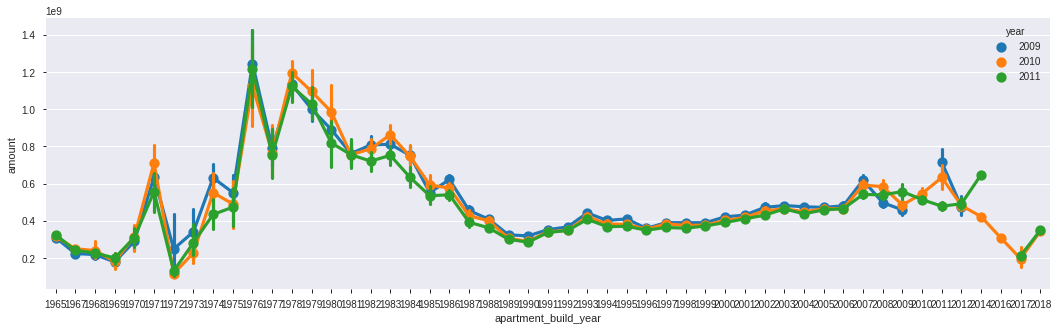

In [0]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 


df1 = df[(df['year']==2011)|(df['year']==2010)|(df['year']==2009)]
sns.pointplot(data=df1,x="apartment_build_year",y="amount",hue='year',ax=ax1)

- 준공연도에 상관없이 2009년도의 거래가가 2010년 2011년도보다 높은 경향인 것으로 보아, 거래연도가 더 중요한 변수

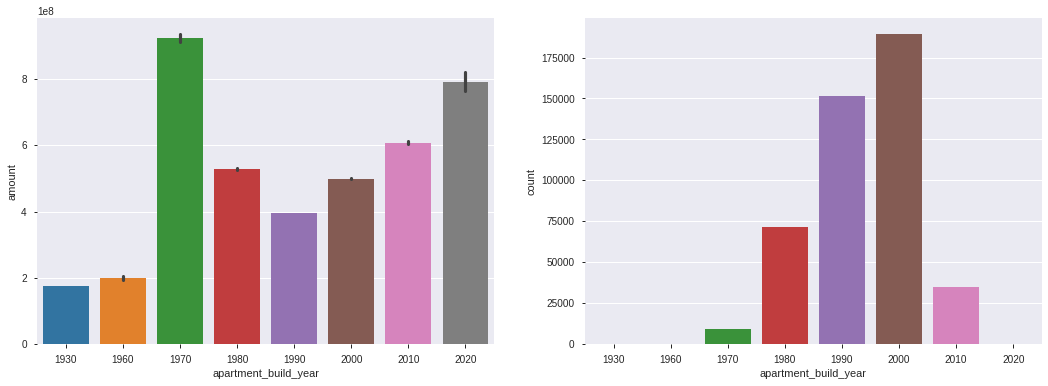

In [0]:
df['apartment_build_year'] = df['apartment_build_year'].apply(lambda x : x - x%10)
a = df['apartment_build_year'].value_counts()
a = pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'index':'apartment_build_year','apartment_build_year':'count'},inplace=True)


figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.barplot(data=df,x="apartment_build_year",y="amount",ax=ax1)
sns.barplot(data=a,x="apartment_build_year",y="count",ax=ax2)

- 1970, 2020년대에 지어진 아파트의 수가 적은거에 비해 amount의 평균이 높다
- 아파트 건축 연도를 일의 자리 수 제외하고 새롭게 설정

In [0]:
df = df.drop(df[df.apartment_build_year==1930].index) #1930년에 지어진 아파트 제거

# 지하철역

In [0]:
df['st_name'].nunique()

296

- 총 296개의 역이 있다

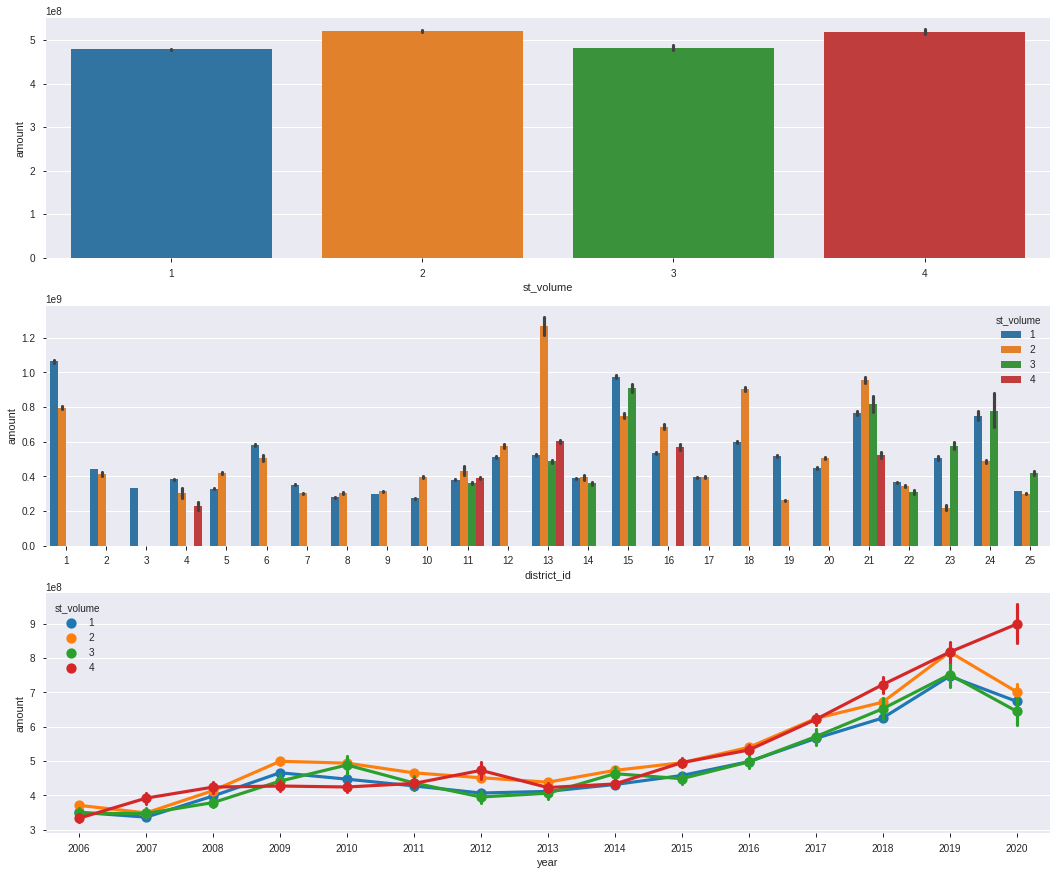

In [0]:
figure,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1)
figure.set_size_inches(18,15) 

sns.barplot(data=df,y='amount',x='st_volume',ax=ax1)
sns.barplot(data=df,y='amount',x='district_id',hue='st_volume',ax=ax2)
sns.pointplot(data=df,y='amount',x='year',hue='st_volume',ax=ax3)

- 환승역이 4개인 곳의 실거래가가 2014년도 이후부터 꾸준히 증가
- 환승역의 개수와 거래액이 큰 상관관계를 보이지 않음 

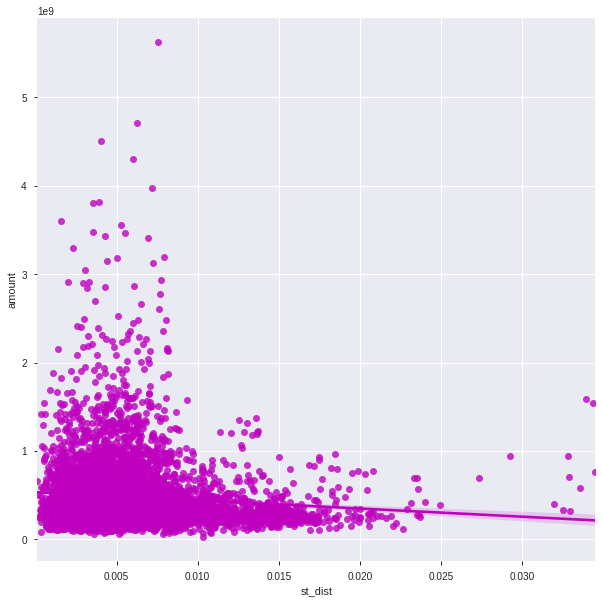

In [0]:
#지하철역과의 거리
a = df.groupby('st_dist').mean()['amount']
a = pd.DataFrame(a).reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(10,10) 

sns.regplot(x="st_dist",y="amount",data=a,color="m",ax=ax1)

- 가까운 역까지의 거리와 거래액은 음의 상관관계를 보인다 
- 이번에는 거리를 구간별로 나눠서 살펴보자

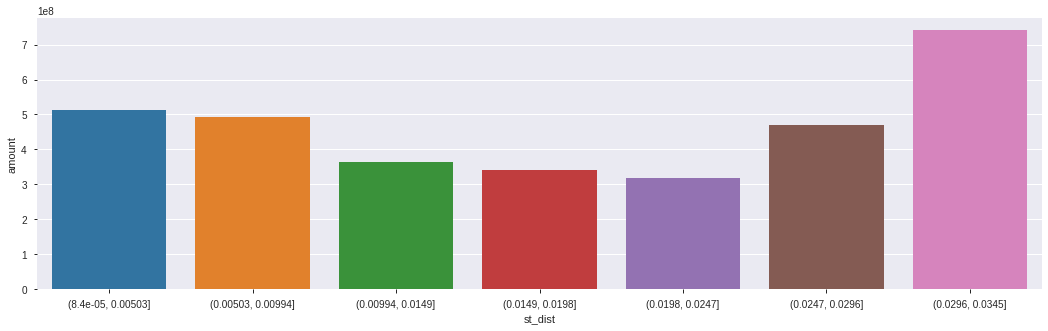

In [0]:
factor = pd.cut(df.st_dist,7)
a = df.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="st_dist",y="amount",ax=ax1)

- 거리가 0.0247 이하인 경우 지하철역에서 거리가 가까울수록 거래가가 비싸지만, 0.0247보다 큰 경우에는 양의 상관관계를 보인다
- 지하철역과 거리가 가장 먼 곳이 가장 높은 평균 거래가를 갖는다(평창동?을 예로 들 수 있을거 같다..자가용 이용..)

In [0]:
df[df['st_dist']>0.0296].head()

,apartment_id,area,year,month,amount,district_id,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,apartment_name,district_name,school_name,school_addr_town,school_students,st_name,st_dist,st_volume
436478,3826,111,2019,1,575000000,23,평창동,롯데건설주식회사,2000,4,10,14,1.64,롯데낙천대,종로구,서울세검정초등학교,세검정로9길,864.0,경복궁역,0.033561,1
436479,3826,111,2018,3,570000000,23,평창동,롯데건설주식회사,2000,4,10,14,1.64,롯데낙천대,종로구,서울세검정초등학교,세검정로9길,864.0,경복궁역,0.033561,1
436480,3826,111,2017,10,500000000,23,평창동,롯데건설주식회사,2000,4,10,14,1.64,롯데낙천대,종로구,서울세검정초등학교,세검정로9길,864.0,경복궁역,0.033561,1
436481,3826,111,2017,8,509999999,23,평창동,롯데건설주식회사,2000,4,10,14,1.64,롯데낙천대,종로구,서울세검정초등학교,세검정로9길,864.0,경복궁역,0.033561,1
436482,3826,111,2017,6,529000000,23,평창동,롯데건설주식회사,2000,4,10,14,1.64,롯데낙천대,종로구,서울세검정초등학교,세검정로9길,864.0,경복궁역,0.033561,1


- 실제로 아파트와 지하철과의 거리가 0.0296보다 먼 동네는 평창동이었다..